### Part 1. Introduction

**Question 1.1:**



In [ ]:
fc = 45 #MPa
rho = 2500 #[kg/m^3]

### Part 2. Nonlinear quasi-static response analysis

In [1]:
import dolfin
import ufl
import numpy as np
import matplotlib.pyplot as plt
from slepc_eigensolver import EigenSolver

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

In [19]:
def stability_monitor(ddE, u, bcs, neig=2,verbose=True):
    eig_solver = EigenSolver(ddE, u, bcs=bcs)
    ncv, it = eig_solver.solve(neig,verbose=verbose) 
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
    min_eig = min(eigenvalues.real)
    return min_eig

In [14]:
# class Material:
#     def __init__(self, E, nu):
#         self.mu_ = 0.5*E/(1+nu)
#         self.lambda_ = 2*0.5*E/(1+nu)*nu/(1-2*nu)

class HyperelasticitySolver:
    DIM = 2
    SOL_DEGREE = 2
    LEFT_INDEX = 1
    RIGHT_INDEX = 2

    def __init__(self, params):
        self.mu_ = dolfin.Constant(0.5*params['Y']/(1+params['nu']))
        self.lambda_ = dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
        self.lambda_ = 2*self.lambda_*self.mu_/(self.lambda_ + 2*self.mu_)
        self.mesh = None 

    def solve(self, params):
        self.mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(params['Lx'], params['Ly']), params['nx'], params['ny'])        
        left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
        right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=params['Lx'])
        boundary_markers = dolfin.MeshFunction("size_t", self.mesh, dim=1, value=0)
        left.mark(boundary_markers, self.LEFT_INDEX)
        right.mark(boundary_markers, self.RIGHT_INDEX)
        ds = dolfin.ds(domain=self.mesh,subdomain_data=boundary_markers)
        dx = dolfin.dx(domain=self.mesh)
        
        V_element = dolfin.VectorElement('CG', ufl.triangle, degree=self.SOL_DEGREE, dim=self.DIM) 
        V = dolfin.FunctionSpace(self.mesh, V_element)
        self.u = dolfin.Function(V, name="u")
        
        I = ufl.Identity(self.DIM)
        F = ufl.variable(I + ufl.grad(self.u))  
        C = F.T*F                   
        Ic = ufl.tr(C)
        J  = ufl.det(F)

        psi = (self.mu_/2)*(Ic - 2) - self.mu_*ufl.ln(J) + (self.lambda_/2)*(ufl.ln(J))**2

        b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "t * rho_g * sin(alpha)"),
                            t=0, alpha=params['alpha'], rho_g=params['rho_g'], degree=0)
        g0 = self.mu_*dolfin.Constant((0.0,0.0)) 
        
        potential_energy = psi*dx - ufl.dot(b0, self.u)*dx - ufl.dot(g0, self.u)*ds(2)
        residual = ufl.derivative(potential_energy, self.u, dolfin.TestFunction(V))
        jacobian = ufl.derivative(residual, self.u, dolfin.TrialFunction(V))
        bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
        problem = dolfin.NonlinearVariationalProblem(residual, self.u, bcs=bcs, J=jacobian)
        solver = dolfin.NonlinearVariationalSolver(problem)

        self.loads = np.linspace(params['load_min'], params['load_max'], params['nsteps'])
        self.displ = np.zeros_like(self.loads)
        self.min_eig = np.zeros_like(self.loads)

        self.u.interpolate(dolfin.Constant((0.,0.)))
        # file_u = dolfin.XDMFFile("output/u.xdmf")
        # file_u.parameters.update({"flush_output": True,
        #                         "functions_share_mesh": True,
        #                         "rewrite_function_mesh": False})

        load_middle = 1.2
        loads_left = np.linspace(params['load_min'], load_middle, int((load_middle - params['load_min'])/(params['load_max'] - params['load_min']) * params['nsteps']), endpoint=False)  
        loads_right = np.linspace(load_middle, params['load_max'], int((params['load_max'] - load_middle)/(params['load_max'] - params['load_min']) * params['nsteps']))  
                            
        for (i, t) in enumerate(loads_left):
            b0.t = t
            solver.solve()
            self.displ[i] = dolfin.assemble(self.u[1]*ds(2))/params['Lx'] 

            self.min_eig[i] = stability_monitor(jacobian, self.u, bcs, neig=2, verbose=False)

        
        b0.alpha = params['alpha_right']
        for (i, t) in enumerate(loads_right):
            b0.t = t
            solver.solve()
            self.displ[loads_left.shape[0] + i] = dolfin.assemble(self.u[1]*ds(2))/params['Lx'] 
            self.min_eig[loads_left.shape[0] + i] = stability_monitor(jacobian, self.u, bcs, neig=2, verbose=False)


        return self.loads, self.displ

    def stress_strain(self):
        self.sigma = self.lambda_ * dolfin.tr(self.epsilon) * ufl.Identity(self.DIM) + 2. * self.mu_ * self.epsilon
        return self.sigma 

    def strain_displacement(self):
        self.epsilon = dolfin.sym(dolfin.grad(self.u))
        return self.epsilon

In [15]:

def solve_hyperelasticity(params, load_max=0.1, nsteps=40, load_min=0, nx=20, ny=5):
    dim = 2
    degree = 2
    mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(params['Lx'], params['Ly']), nx, ny)
    # plt.figure(0)
    # dolfin.plot(mesh)
    left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
    right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=params['Lx'])
    boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
    left_index = 1
    right_index = 2
    left.mark(boundary_markers, left_index)
    right.mark(boundary_markers, right_index)
    ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
    dx = dolfin.dx(domain=mesh)
    
    V_element = dolfin.VectorElement('CG', ufl.triangle, degree=degree, dim=dim) 
    V = dolfin.FunctionSpace(mesh, V_element)
    u = dolfin.Function(V, name="u")
    
    I = ufl.Identity(dim)
    F = ufl.variable(I + ufl.grad(u))  
    C = F.T*F                   
    Ic = ufl.tr(C)
    J  = ufl.det(F)
    E = 1/2*(C-I)
    Y = params['Y']
    nu = params['nu']
    
    mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
    lmbda = 2*lmbda*mu/(lmbda + 2*mu) 
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
    
    # b0 = dolfin.Expression(("0.0", "t*mu"), t=0, mu=mu, degree=0)  
    b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "t * rho_g * sin(alpha)"),
                        t=0, alpha=params['alpha'], rho_g=params['rho_g'], degree=0)
    g0 = mu*dolfin.Constant((0.0,0.0)) 
    
    potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(2)
    residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
    jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
    bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
    problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
    solver = dolfin.NonlinearVariationalSolver(problem)
    loads = np.linspace(load_min, load_max, nsteps)
    displ = np.zeros_like(loads)
    ux = np.zeros_like(loads)
    uy = np.zeros_like(loads)
    u.interpolate(dolfin.Constant((0.,0.)))
    file_u = dolfin.XDMFFile("output/u.xdmf")
    file_u.parameters.update({"flush_output": True,
                              "functions_share_mesh": True,
                              "rewrite_function_mesh": False})
    for (i, t) in enumerate(loads):
        b0.t = t
        solver.solve()
        displ[i] = dolfin.assemble(u[1]*ds(2))/params['Lx'] 
        # ux[i] = u[0](Lx, params['Ly']/2)
        # uy[i] = u[1](Lx, Ly/2)
        # plt.figure(1)
        # dolfin.plot(u, mode = "displacement")
        # print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
        # with file_u as file:
        #     file.write(u, t)
    plt.figure(2)
    plt.plot(loads,displ,"o")
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.savefig("output/displacement.png")
    return (mesh, loads, displ)

#### Question 2.1

In [16]:
Lx = 1 #[m]
Y = 1100 #[Pa]
nu = 0.35 #[-]
Ly = 0.1*Lx
alpha = 0.1
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3

params = {'Lx':Lx, 'Y':Y, 'nu':nu, 'Ly':Ly, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho_g, 'load_max':2, 'nsteps':40, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right': alpha}
hypsol = HyperelasticitySolver(params)

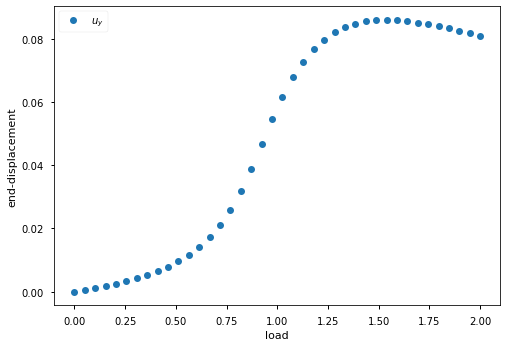

In [17]:
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

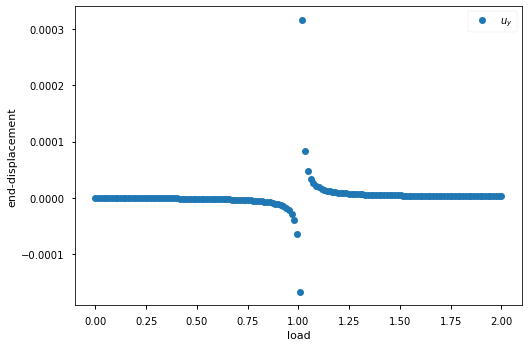

In [126]:
params['alpha'] = 0
params['alpha_right'] = 0
params['nsteps'] = 150

params['max_loads'] = 1.2
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

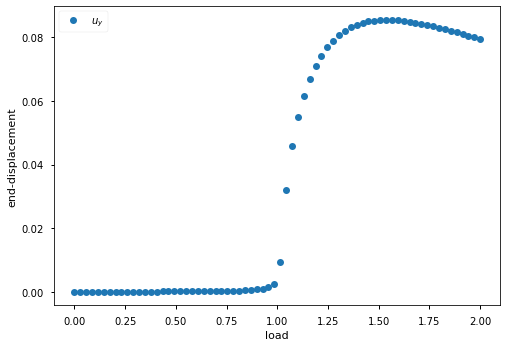

In [123]:
params['alpha'] = 0.001
params['alpha_right'] = 0.001
params['nsteps'] = 70

loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

#### Question 2.2

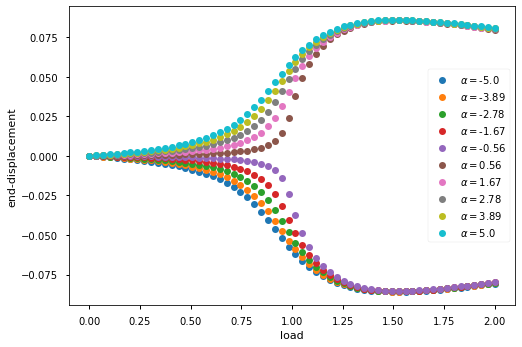

In [39]:
params['nsteps'] = 60
alphas = np.linspace(-5*np.pi/180, 5*np.pi/180, 10)
for alpha in alphas:
    params['alpha'] = alpha
    loads, displ = hypsol.solve(params)
    plt.plot(loads, displ, "o", label=(r'$\alpha = $'+str(round(alpha*180/np.pi,2))))
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.legend()

#### Question 2.3

### Part 3. (Nonlinear) Bridge design

In [13]:
Y = 37e9 #[Pa]
Ly = 10 #[m]
g = 9.8 #[m/s^2]
rho = 2500 #[kg/m^3]

nu = 0.35 #[-]
fc = 46e6 #[Pa]
alpha = 0.0045
# alpha = 10*np.pi/180
Gamma = 7.8

params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y, 'load_max':1.5, 'nsteps':50, 'load_min':0, 'nx':30, 'ny':10 }

print('Theoretical Lx =', pow(Gamma * Y * Ly**2 / (rho * g), 1./3.))

Theoretical Lx = 1056.1122517055744


#### Question 3.1

500.0
508.33333333333337
516.6666666666666
525.0
533.3333333333334
541.6666666666666
550.0


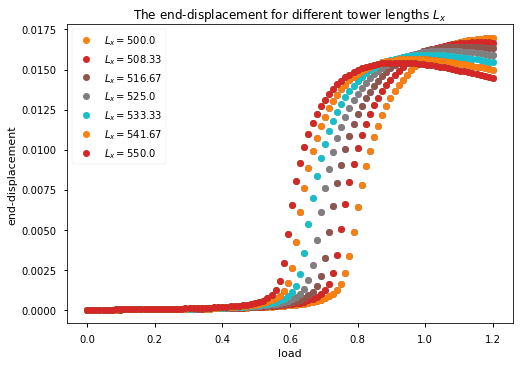

In [28]:
ks = np.linspace(50, 55, 7)
max_loads = ks * 0.
for i, k in enumerate(ks):
    Lx = k * Ly
    params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y }

    _, loads, displ = solve_hyperelasticity(load_max=1.2, nsteps=100, load_min=0, nx=30, ny=20, params=params)
    max_loads[i] = loads[np.argmax(displ)]
    plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))))
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.legend()
    plt.title('The end-displacement for different tower lengths ' + r'$L_x$')


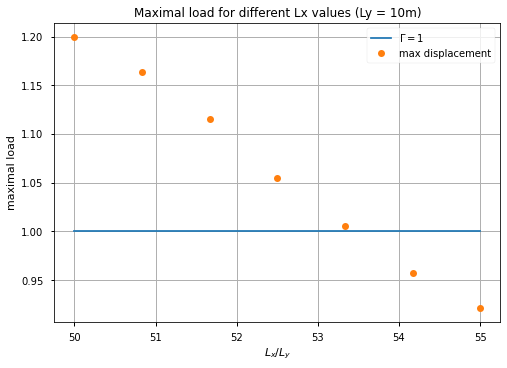

In [29]:
ref_load = np.full(max_loads.shape, 1)
plt.plot(ks, ref_load, label=r'$\Gamma = 1$')
plt.plot(ks, max_loads, "o", label='max displacement')
plt.xlabel(r'$L_x/L_y$')
plt.ylabel("maximal load")
plt.title('Maximal load for different Lx values (Ly = 10m)')
plt.grid()
plt.legend()

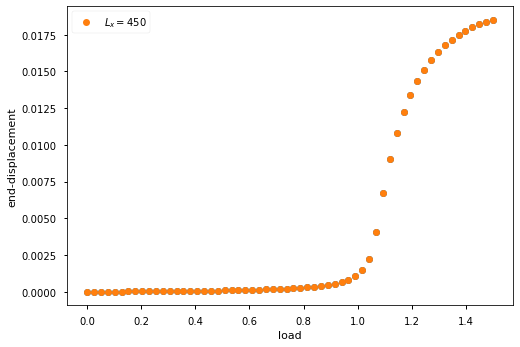

In [15]:
# For testing
k = 45
Lx = k * Ly
params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y }

mesh, loads, displ = solve_hyperelasticity(load_max=1.5, nsteps=60, load_min=0, nx=30, ny=10, params=params)
max_loads[i] = loads[np.argmax(displ)]
plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()
# dolfin.plot(mesh)


#### Question 3.2

In [8]:
k = 30
Lx = k * Ly
params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y }

_, loads, displ = solve_hyperelasticity(load_max=1.5, nsteps=50, load_min=0, nx=30, ny=10, params=params)
max_loads[i] = loads[np.argmax(displ)]
plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()


KeyboardInterrupt: 

In [9]:
Lx = 30 * Ly
params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y, 'load_max':1.5, 'nsteps':50, 'load_min':0, 'nx':30, 'ny':10 }
hypsol = HyperelasticitySolver(params)
params

{'Lx': 1,
 'Y': 1.0,
 'nu': 0.35,
 'Ly': 0.03333333333333333,
 'alpha': 0.0045,
 'Gamma': 7.8,
 'rho_g': 0.00019864864864864865,
 'load_max': 1.5,
 'nsteps': 50,
 'load_min': 0,
 'nx': 30,
 'ny': 10}

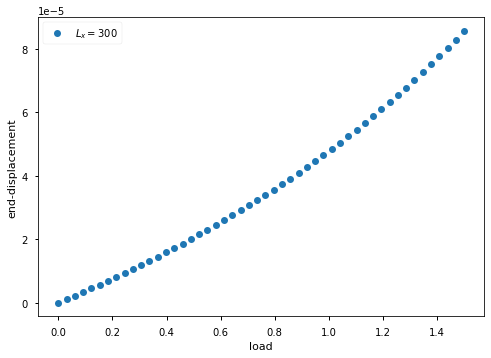

In [ ]:
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()


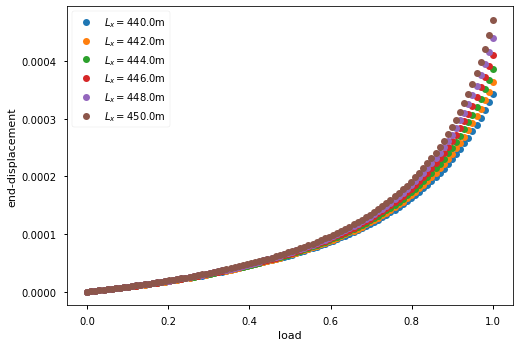

In [32]:
ks = np.linspace(44, 45, 6)
max_stress = ks * 0.
hypsol = HyperelasticitySolver(params)
plt.figure(1)

for i, k in enumerate(ks):
    Lx = k * Ly
    params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y, 'load_max':1, 'nsteps':100, 'load_min':0, 'nx':30, 'ny':10 }
    
    loads, displ = hypsol.solve(params)

    stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
    hypsol.strain_displacement()
    sigma = hypsol.stress_strain()
    fe_sigma_xx = dolfin.project(sigma[0,0], stress_field_space)

    max_stress[i] = np.min(fe_sigma_xx.compute_vertex_values())
    
    plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))) + 'm')
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.legend()

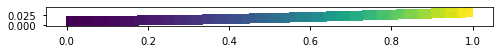

In [33]:
dolfin.plot(hypsol.u, mode = "displacement")

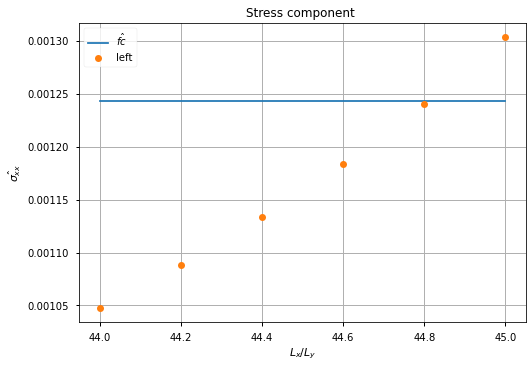

In [34]:
sigma_C_ref = np.full(ks.shape, fc/Y)
plt.plot(ks, sigma_C_ref, label=r'$\hat{fc}$')
plt.plot(ks, np.abs(max_stress), "o", label=('max |sxx|'))
plt.xlabel(r'$L_x/L_y$')
plt.ylabel(r'$\hat{\sigma_{xx}}$')
plt.title('Stress component ')
plt.grid()
plt.legend()


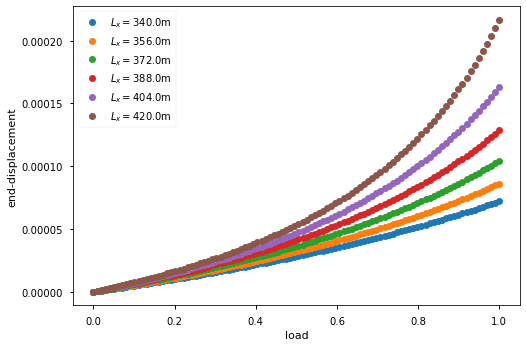

In [55]:
ks = np.linspace(34, 42, 6)
max_stress = ks * 0.
left_stress = ks * 0.
right_stress = ks * 0.
hypsol = HyperelasticitySolver(params)
plt.figure(1)

for i, k in enumerate(ks):
    Lx = k * Ly
    params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y, 'load_max':1, 'nsteps':100, 'load_min':0, 'nx':30, 'ny':10 }
    
    loads, displ = hypsol.solve(params)

    stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
    hypsol.strain_displacement()
    sigma = hypsol.stress_strain()
    fe_sigma_xx = dolfin.project(sigma[0,0], stress_field_space)
    fe_sigma_yy = dolfin.project(sigma[1,1], stress_field_space)

    max_stress[i] = fe_sigma_yy(0, params['Ly'])
    left_stress[i] = np.max(fe_sigma_xx.compute_vertex_values())
    right_stress[i] = np.max(fe_sigma_yy.compute_vertex_values())

    plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))) + 'm')
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.legend()

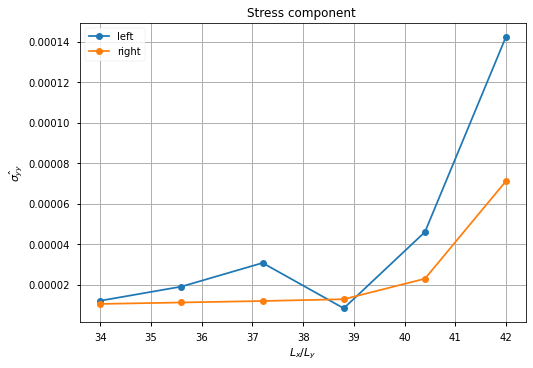

In [56]:
# plt.plot(ks, np.abs(max_stress), "o", label=('left'))
plt.plot(ks, np.abs(left_stress), "o-", label=('left'))
plt.plot(ks, np.abs(right_stress), "o-", label=('right'))
plt.xlabel(r'$L_x/L_y$')
plt.ylabel(r'$\hat{\sigma_{yy}}$')
plt.title('Stress component ')
plt.grid()
plt.legend()


#### Question 3.6

sigma_eq - safe zone ?

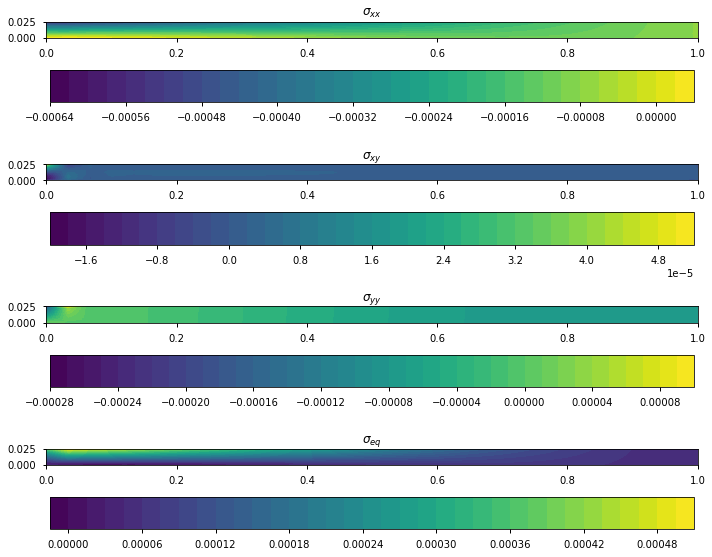

In [ ]:
stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
hypsol.strain_displacement()
sigma = hypsol.stress_strain()
s = sigma - (1./3)*dolfin.tr(sigma)*dolfin.Identity(2)  # deviatoric stress
von_Mises = dolfin.sqrt(3./2*dolfin.inner(s, s))
von_Mises = dolfin.project(von_Mises, stress_field_space)

plt.figure(figsize=[10, 8])

plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(hypsol.sigma[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(hypsol.sigma[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(hypsol.sigma[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.subplot(4, 1, 4)
plt.colorbar(dolfin.plot(von_Mises), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{eq}$')

plt.tight_layout()

### Part 10

#### Question 10.1

In [101]:
Lx = 1 #[m]
Y = 1100 #[Pa]
nu = 0.35 #[-]
Ly = 0.1
alpha = 0
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3

params = {'Lx':Lx, 'Y':Y, 'nu':nu, 'Ly':Ly, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho_g, 'load_max':2, 'nsteps':40, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right':0.01}
hypsol = HyperelasticitySolver(params)

(60,) (40,)


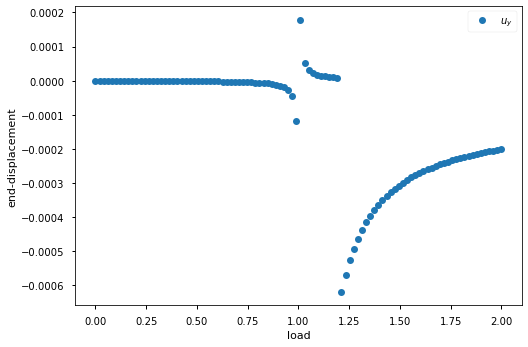

In [104]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

#### Question 10.2

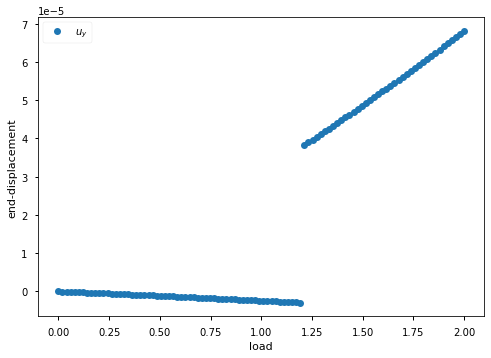

In [36]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
params['Ly'] = 0.35
loads, displ = hypsol.solve(params)

plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

#### Question 10.3

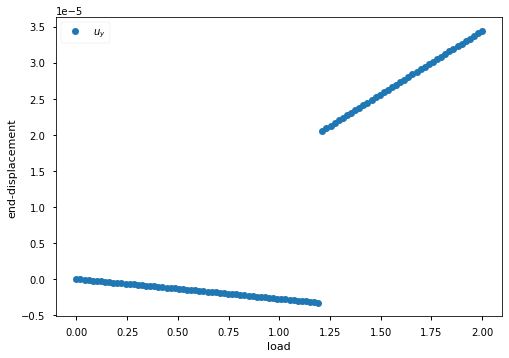

In [38]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
params['Ly'] = 0.95
loads, displ = hypsol.solve(params)

plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

### Part 20

In [40]:
Lx = 1 #[m]
Y = 1100 #[Pa]
nu = 0.35 #[-]
Ly = 0.1*Lx
alpha = 0
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3

params = {'Lx':Lx, 'Y':Y, 'nu':nu, 'Ly':Ly, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho_g, 'load_max':2, 'nsteps':40, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right':0.01}
hypsol = HyperelasticitySolver(params)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


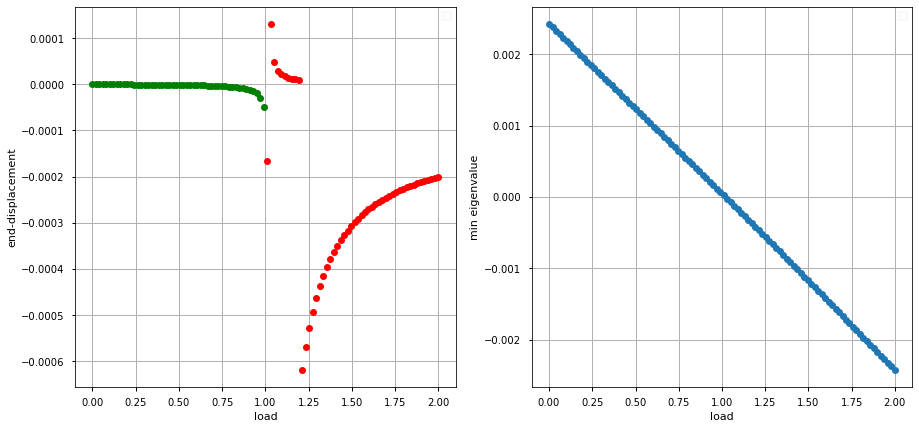

In [49]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(loads[loads<1], displ[loads<1], "og")
plt.plot(loads[loads>1], displ[loads>1], "or")
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(loads, hypsol.min_eig, "o")
plt.xlabel("load")
plt.ylabel("min eigenvalue")
plt.legend()
plt.grid()


No handles with labels found to put in legend.


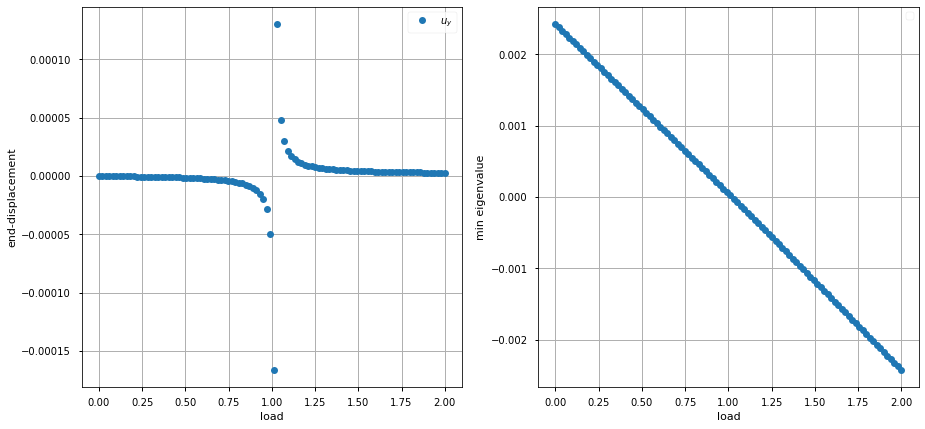

In [29]:
params['alpha'] = 0
params['alpha_right'] = 0.0
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(loads, hypsol.min_eig, "o")
plt.xlabel("load")
plt.ylabel("min eigenvalue")
plt.legend()
plt.grid()


No handles with labels found to put in legend.


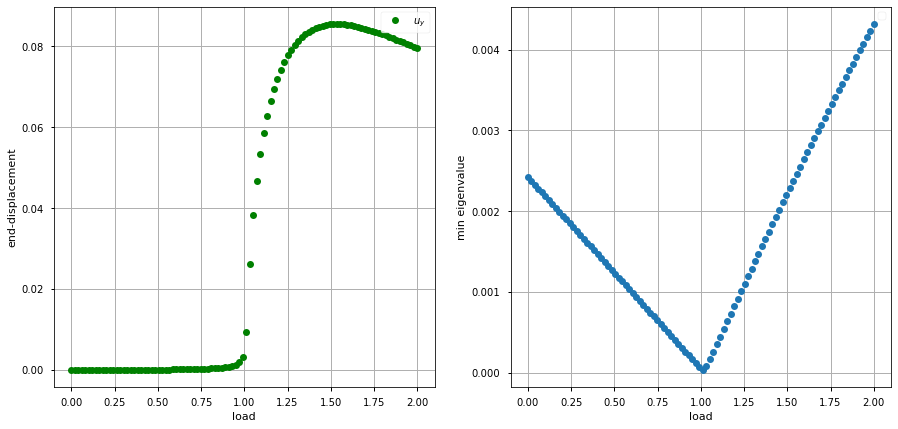

In [43]:
params['alpha'] = 0.001
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(loads, displ, "og", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(loads, hypsol.min_eig, "o")
plt.xlabel("load")
plt.ylabel("min eigenvalue")
plt.legend()
plt.grid()
